<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL_DoubleMassAnalysis/blob/main/SiteCharacterization01_19_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
import statsmodels.api as sm
from functools import reduce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/Projects/Work/SiteComparisons/SWE

/content/gdrive/My Drive/Projects/Work/SiteComparisons/SWE


In [ ]:
ls

OR_SWE_diff_ways_to_extract_text.xlsx  OR_SWE.xlsx  WA_SWE.xlsx


## Import SWE Data from OR and WA Sites and merge into single dataframe

In [5]:
WA_Sites = pd.read_excel('WA_SWE.xlsx')
# pd.to_datetime(WA_Sites['Date'])
WA_Sites.set_index('Date',inplace=True)
WA_Sites.sample(5)

OR_Sites = pd.read_excel('OR_SWE.xlsx')
# pd.to_datetime(OR_Sites['Date'])
OR_Sites.set_index('Date',inplace=True)
OR_Sites.sample(5)

ORWA_Sites = pd.merge(OR_Sites,WA_Sites,left_index=True,right_index=True)
ORWA_Sites.sample(5)

,Aneroid Lake #2 (302),Annie Springs (1000),Arbuckle Mtn (304),Bear Grass (1166),Beaver Reservoir (331),Big Red Mountain,Bigelow Camp (343),Billie Creek Divide,Blazed Alder (351),Blue Mountain Spring,Bourne (361) Snow,Bowman Springs (362),Cascade Summit (388),Chemult Alternate (395),Clackamas Lake (398),Clear Lake (401),Cold Springs Camp,County Line (422),Crazyman Flat (1010),Daly Lake (434),Derr. (440) Snow,Diamond Lake (442),Eilertson Meadows (464),Emigrant Springs (470),Fish Creek (477),Fish Lk. (479),Fourmile Lake (483),Gerber Reservoir (945),Gold Center (494),Greenpoint (504) Snow,High Ridge (523),Hogg Pass (526),Holland Meadows (529),Howard Prairie (1158),Irish Taylor (545),Jump Off Joe (552),King Mountain (558),Lake Creek R.S. (563),Little Meadows (584),Lucky Strike (605),...,Mowich (941),Mt. Tebo (1126),Muckamuck (1259),Olallie Meadows (672),Paradise (679),Park Creek Ridge (681),Pepper Creek (1104),Pigtail Peak (692),Pinto Rock (1263),Pope Ridge (699),Potato Hill (702),Quartz Peak (707),Rainy Pass (711)),Rex River (911),Salmon Meadows (728)),Sasse Ridge (734),Satus Pass (1231),Sawmill Ridge (1068),Sentinel Butte (1043),Sheep Canyon (748),Skate Creek (1257),Skookum Creek (912),Sourdough Gulch (985),Spencer Meadow (776),Spirit Lake (777),Spruce Springs (984),Stampede Pass (788),Stevens Pass (791),Surprise Lakes (804),Swamp Creek (975),Swift Creek (1012),Thunder Basin (817),Tinkham Creek (899),Touchet (824),Trinity (1171),Trough (832),Upper Wheeler (841),Waterhole (974),Wells Creek (909),White Pass E.S. (863)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-11-01,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,NaN,1.4,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.1,0.0,0.0,0.0,NaN,NaN,NaN,0.1,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
2005-03-19,10.3,19.2,7.7,NaN,4.5,18.0,0.4,2.3,0.9,5.0,3.0,0.0,11.8,0.3,0.0,0.2,3.0,0.0,8.9,0.0,9.7,0.0,1.7,0.0,14.1,0.0,8.9,0.0,0.0,0.7,5.1,6.0,0.4,NaN,18.4,0.0,0.0,2.6,3.9,0.0,...,0.0,NaN,NaN,6.9,22.5,7.3,NaN,13.0,NaN,4.8,0.0,0.8,12.2,1.5,4.0,7.6,NaN,NaN,3.9,0.8,NaN,1.8,0.0,2.0,0.3,0.1,3.2,7.7,8.8,0.3,16.2,8.5,2.2,5.2,NaN,0.2,4.6,2.0,9.7,0.8
2000-08-28,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
1987-05-06,12.0,NaN,1.3,NaN,0.0,10.6,0.0,0.0,0.0,0.0,0.0,0.0,9.5,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,10.0,0.0,7.7,NaN,0.0,0.0,0.0,19.1,0.0,NaN,30.1,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,40.3,55.7,28.0,NaN,24.6,NaN,0.0,4.3,NaN,34.1,NaN,0.0,11.6,NaN,NaN,NaN,11.2,NaN,NaN,NaN,8.2,0.0,NaN,23.6,21.1,22.3,NaN,NaN,NaN,NaN,1.1,NaN,0.0,0.0,NaN,NaN,8.2
1984-05-14,33.5,NaN,31.2,NaN,0.4,29.4,0.0,20.2,28.0,18.0,18.6,0.0,35.5,0.0,0.0,9.6,40.0,0.0,NaN,0.0,15.7,6.3,2.7,0.0,51.7,0.0,36.7,NaN,0.0,0.0,8.2,43.2,21.5,NaN,54.4,0.0,0.0,0.0,23.3,2.3,...,NaN,NaN,NaN,56.8,70.3,33.5,NaN,54.5,NaN,0.0,17.0,NaN,34.0,NaN,4.0,NaN,NaN,NaN,NaN,46.2,NaN,NaN,NaN,17.0,NaN,NaN,44.7,33.6,59.8,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.2,NaN,NaN,23.6


## Exploratory Analysis

#### Take a look at NaN/missing values in SWE for each station

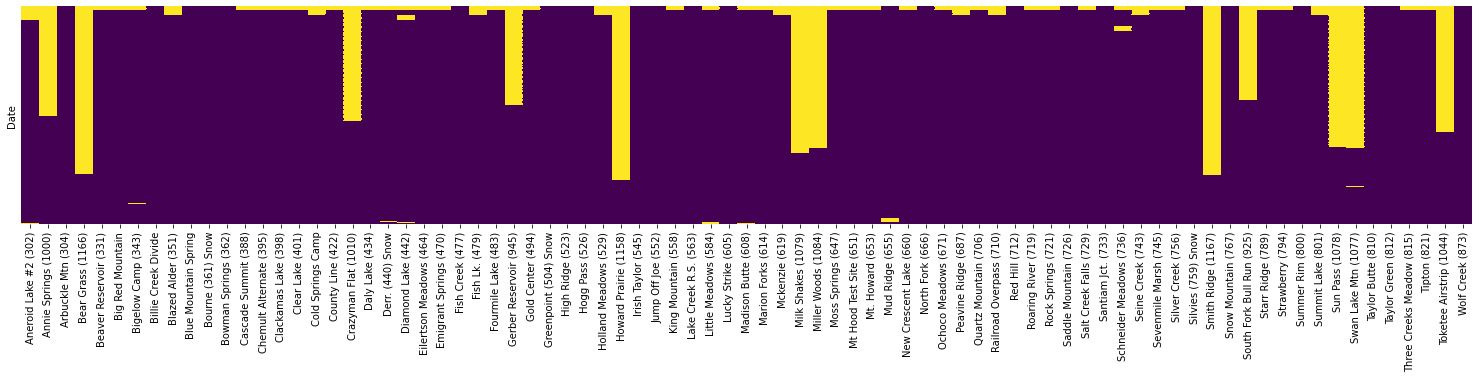

In [6]:
#Heatmap of missing data for OR Stations.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,4))
sns.heatmap(OR_Sites.isnull(),yticklabels=False,cbar=False,cmap='viridis')

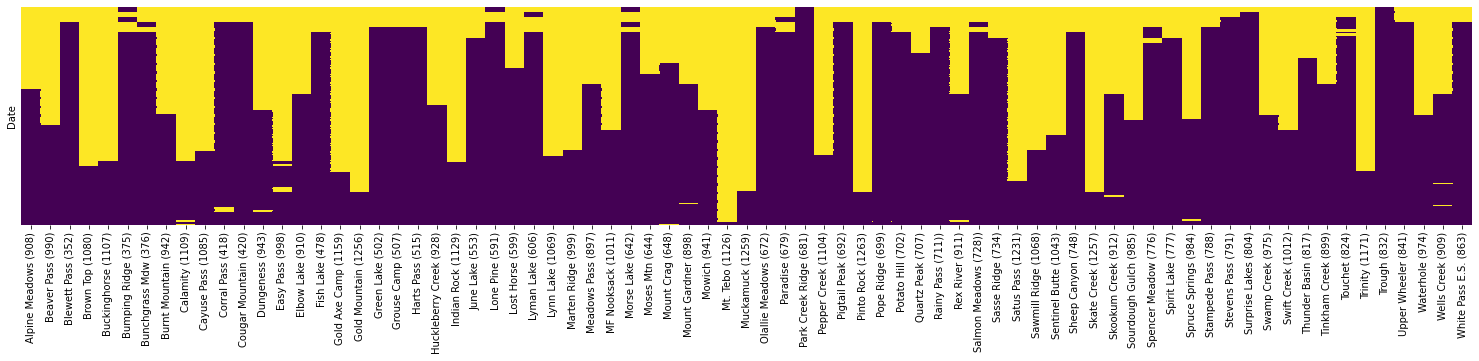

In [7]:
#Heatmap of missing data for OR Stations.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,4))
sns.heatmap(WA_Sites.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Check SWE distribution filtered only days when SWE > 0.

In [ ]:
#OR Sites
import plotly.graph_objects as go
fig = go.Figure()
for i in OR_Sites.columns:
  OR = OR_Sites[OR_Sites[str(i)] != 0].dropna()
  fig.add_trace(go.Box(y = OR[i], name = str(i)))

fig.update_layout(
    autosize=False,
    width=1600,
    height=400,
    margin=dict(l=20, r=20, t=2, b=8),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [8]:
#WA Sites
fig = go.Figure()
for i in WA_Sites.columns:
  WA = WA_Sites[WA_Sites[i] != 0].dropna()
  fig.add_trace(go.Box(y = WA[i], name = str(i)))
fig.update_layout(
    autosize=False,
    width=1600,
    height=400,
    margin=dict(l=20, r=20, t=2, b=8),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Double Mass Analysis

In [11]:
def double_mass3(*args, month, time_freq, event_date):  #If you set month to a default, python sees it as a key-value argument which will break *args.
  

 #Compile and filter data with respect to double_mass3 function inputs:

  site_list = [ORWA_Sites[args[i]].dropna().resample(time_freq).sum() for i in range(0, len(args))] 
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged.resample(time_freq).sum()
  # print(df2)  


  if month == 0:
    df2 = df2
    # print(df2)
  
  elif month > 0 or month < 12:
    df2 = df2[df2.index.month == 11] #need to understand indexes and datatime indexes better.  When to use .dt accessor?


#Double Mass Analysis
  x=pd.DataFrame(df2.iloc[:,0].cumsum())
  x.columns = ['x']
  y=pd.DataFrame(np.add.reduce([df2.iloc[:,i].cumsum() for i in range(0, len(args))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  y.index = x.index
  y.columns= ['y']

#Run t test stat analysis with specified event_date as the middle between the two datasets

  df = pd.DataFrame(df2.iloc[:,0][len(df2.iloc[:,0]) - 2*len(df2.iloc[:,0][df2.iloc[:,0].index > event_date]):len(df2.iloc[:,0])])
  df = np.split(df,2)

  ttest = stats.ttest_ind(df[0], df[1])
  statistic = ttest[0]
  pvalue = ttest[1]
  print('Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)')
  print('Calculated t test statistic: {:.2f}.  Calculated p value: {:.2f}'.format(statistic[0], pvalue[0]))
  if pvalue < 0.05:
    print('The p value obtained from T-test analysis is significant (p value < 0.05), and therefore, we reject the H0 as there is a significant difference between means.')
  else:
    print('The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.')

#Plot the data

  customdata_list = [df2.iloc[:,0], x, y]
  customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
  customdata.reset_index(inplace=True)

  # fig = go.Figure()
  fig = make_subplots(
      rows=2, cols=1,
      subplot_titles=("SWE Double Mass Curve", "Daily SWE (%s)" % (df2.columns[0]))
  )

  fig.add_trace(go.Scatter(
      x=x.iloc[:,0],
      y=y.iloc[:,0],
      mode='lines',
      customdata=customdata,
      hovertemplate = '<b>Date: %{customdata[0]}</b><br>Site of Interest - Cumulative SWE (in): %{customdata[2]:.2f}</br>Comparison Site(s) - Cumulative SWE (in): %{customdata[3]:.2f}<br>Site of Interest - SWE (in): %{customdata[1]:.2f}</br>',
      name = 'Site of interest: {}'.format(df2.columns[0])
  ),
      row=1, col=1
  )

  fig.add_trace(go.Scatter(
      x=x.iloc[:,0][x.index==event_date],
      y=y.iloc[:,0][y.index==event_date],
      mode='markers',
      name='Date of event: {}'.format(event_date),
      marker_color='red'
  ),
      row=1, col=1
  )


  fig.add_trace(go.Scatter(
      x=df2.index,
      y=df2.iloc[:,0],
      name= 'Daily SWE - {}'.format(df2.columns[0])
  ),
      row=2,col=1
  )

  fig.add_trace(go.Scatter(
    x=df2.index[df2.iloc[:,0].index==event_date],
    y=df2.iloc[:,0][df2.iloc[:,0].index==event_date],
    mode='markers',
    name='Date of event: {}'.format(event_date),
    marker_color='red'
  ),
    row=2, col=1
  )

  fig.update_xaxes(title_text="Cumulative SWE at site of interest (%s)" % (df2.columns[0]), row=1, col=1)
  fig.update_xaxes(title_text='Date', row=2, col=1)

  fig.update_yaxes(title_text="Total Cumulative SWE of all Comparison Sites {}".format(args[1::]), row=1, col=1)
  fig.update_yaxes(title_text="Daily SWE (in)", row=2, col=1)

  # comparison_sites_list = list(args)
  fig.update_layout(
   height=850,
   width=1200,
  #  title={
  #       # 'text': 'SWE Double Mass Curve',
  #       'y':.94,
  #       'x':0.5,
  #       'xanchor': 'center',
  #       'yanchor': 'top'},
  #   xaxis_title="Cumulative SWE at site of interest (%s)" % (df2.columns[0]),
  #   yaxis_title="Total Cumulative SWE of all Comparison Sites {}".format(args[1::]),
  #   xaxis2=dict(title='Date',
  #               overlaying='y',
  #               side='right'),   
  )

  fig.show()


## Double Mass Analysis for various sites

### Fire: site burned entirely

In [12]:
double_mass3('Corral Pass (418)', 'Huckleberry Creek (928)', 'Morse Lake (642)', month=1, time_freq = 'W', event_date='2017-10-05')

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: -0.23.  Calculated p value: 0.82
The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.


In [13]:
double_mass3('Diamond Lake (442)', 'Summit Lake (801)', month=0, time_freq = 'W', event_date='2020-05-31')  #'Annie Springs (1000)'
#Burnt down somtime in late summer fires of 2020.

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: 5.46.  Calculated p value: 0.00
The p value obtained from T-test analysis is significant (p value < 0.05), and therefore, we reject the H0 as there is a significant difference between means.


### Fire nearby, but site remained intact

In [14]:
WA_Sites['Moses Mtn (644)'].sample(10)

Date
1993-07-11     0.0
2002-04-07    16.4
2001-03-19     7.0
2016-02-13    13.6
1996-03-31    14.9
1993-07-25     0.0
1999-07-30     0.0
2019-09-04     0.0
2003-08-30     0.0
2020-05-27     0.0
Name: Moses Mtn (644), dtype: float64

In [15]:
double_mass3('Moses Mtn (644)', 'Sentinel Butte (1043)', month=2, time_freq = 'D', event_date='09-10-2003')
#Installed snow pillow on 9/4/2003 at Sentinel Butte.
#Moses installed 2003/4

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: 0.01.  Calculated p value: 0.99
The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.


In [16]:
double_mass3('Sasse Ridge (734)', 'Fish Lake (478)','Olallie Meadows (672)','Stampede Pass (788)', month=0, time_freq = 'M', event_date='07-05-2017')

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: 0.76.  Calculated p value: 0.45
The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.


In [17]:
double_mass3('Sentinel Butte (1043)', 'Moses Mtn (644)',month=0, time_freq = 'W', event_date='04-16-2017') #, 'Bunchgrass Mdw (376)'

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: 0.14.  Calculated p value: 0.89
The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.


In [18]:
double_mass3('Mckenzie (619)', 'Bear Grass (1166)', 'Hogg Pass (526)', month=0, time_freq = 'M', event_date='02-29-2012') #, 'Bunchgrass Mdw (376)'
#nothing obvious is sitevisit log that would indicate a reason for the data to change in 2012 at McKenzie, Bear Grass, or Hogg Pass
#Bear was installed Sep 2011

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: -1.22.  Calculated p value: 0.22
The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.


### Pillow Alterations

In [19]:
double_mass3('Roaring River (719)', 'Irish Taylor (545)', 'Cascade Summit (388)', month=0, time_freq='W', event_date='2019-04-28')

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: 1.65.  Calculated p value: 0.10
The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.


In [20]:
double_mass3('Railroad Overpass (710)', 'Salt Creek Falls (729)', month=0, time_freq='W', event_date='2018-03-04')  #'Holland Meadows (529)', 'Cascade Summit (388)'

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: 0.11.  Calculated p value: 0.91
The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.


In [21]:
double_mass3('Mud Ridge (655)', 'Clear Lake (401)','Red Hill (712)', time_freq='W', month=0,event_date='2017-05-21' ) #'Clackamas Lake (398)', 'Mt Hood Test Site (651)'

Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)
Calculated t test statistic: 2.68.  Calculated p value: 0.01
The p value obtained from T-test analysis is significant (p value < 0.05), and therefore, we reject the H0 as there is a significant difference between means.


## Scratch pad code

#### Prep'ing data for statistical tests

16.923788135973332 4.1356038837454366e-05
nan nan
count    651.000000
mean       3.875730
std        5.834064
min        0.000000
25%        0.000000
50%        0.000000
75%        6.000000
max       20.600000
Name: Moses Mtn (644), dtype: float64
count    651.000000
mean       2.743318
std        3.910439
min        0.000000
25%        0.000000
50%        0.000000
75%        5.700000
max       11.700000
Name: Moses Mtn (644), dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



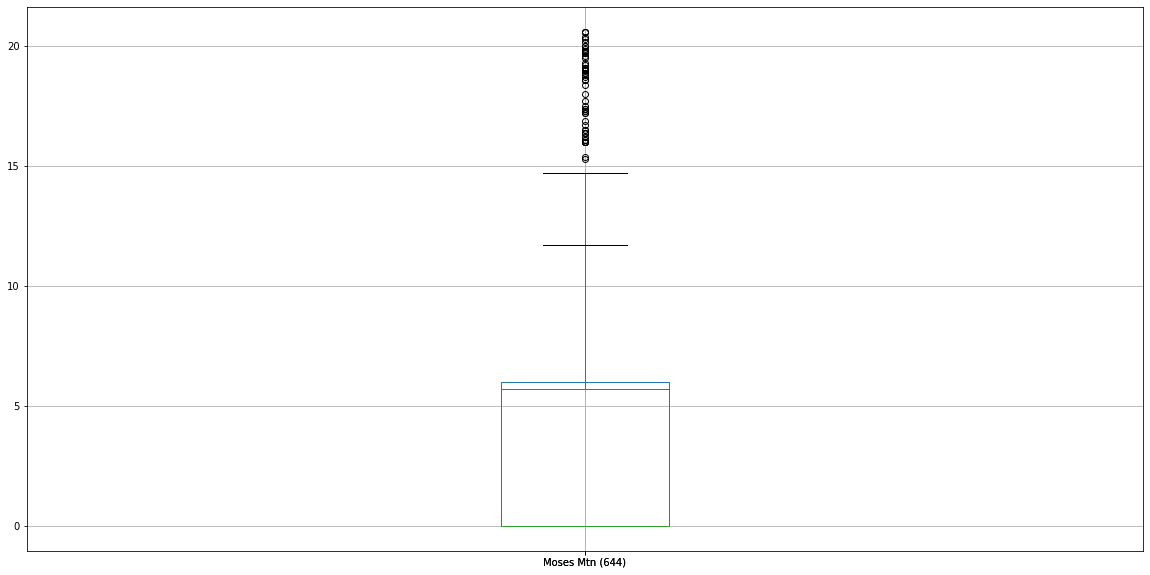

In [ ]:
# site_list2 = []
#     for i in range(0, len(site_list)):
#       site_list2.append(ORWA_Sites[site_list[i]].dropna())

event_date = '2019-03-01'

site_list = ('Moses Mtn (644)', 'Sentinel Butte (1043)','Annie Springs (1000)')
site_list2 = []
for i in range(0, len(site_list)):
  site_list2.append(ORWA_Sites[site_list[i]].dropna())

# site_list2
x=site_list2[0]
y=(np.add.reduce(site_list2))
x1=site_list2[0].cumsum()
y1=(np.add.reduce(site_list2)).cumsum()

df = x[len(x) - 2*len(x[x.index > event_date]):len(x)]
df1 = y[len(y) - 2*len(y[y.index > event_date]):len(y)]

df = np.split(df,2)
df1 = np.split(df1,2)

fvalue, pvalue = stats.f_oneway(df[0], df[1])
fvalue1, pvalue1 = stats.f_oneway(df1[0], df1[1])
print(fvalue, pvalue)
print(fvalue1, pvalue1)
print(df[0].describe())
pd.DataFrame(df[0]).boxplot()
print(df[1].describe())
pd.DataFrame(df[1]).boxplot()

#### Reducing for year and month scales

In [ ]:
def double_mass(*args, month, scale):  #If you set month to a default, python sees it as a key-value argument which won't make *args work.
  
  if scale = year:
    np.reduce



  site_list = args

  if month == 0:
    site_list2 = []
    for i in range(0, len(site_list)):
      site_list2.append(ORWA_Sites[site_list[i]].dropna())

  elif month > 0 or month < 12:
    site_list1 = []
    for i in range(0, len(site_list)):
      site_list1.append(ORWA_Sites[site_list[i]].dropna())
      
    site_list2 = []
    for j in range(0, len(site_list)):
      site_list2.append(site_list1[j][site_list1[j].index.month==month])
  
  else:
    print('select month (1-12)')


  x=site_list2[0].cumsum()
  y=(np.add.reduce(site_list2)).cumsum()

  # res = sm.OLS(y, x).fit().fittedvalues
  # print(res)

  customdata = pd.DataFrame(zip(site_list2[0].reset_index()['Date'], x, y)) #Can also use np.c_
  
    
  fig = go.Figure()
  
  fig.add_trace(go.Scatter(
      x=x,
      y=y,
      mode='lines',
      customdata=customdata,
      hovertemplate = 'Date: <b>%{customdata[0]}</b><br> x-Axis Accumulative SWE (in): %{customdata[1]}</br><br> y-Axis Accumulative SWE (in): %{customdata[2]}</br>',
      name = 'Site of interest: {}'.format(site_list2[0].name)
  ))

  fig.update_layout(
   height=900,
   width=900,
   title={
        'text': 'SWE Double Mass Analysis',
        'y':.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Accumulative SWE at site of interest (%s)" % (site_list2[0].name),
    yaxis_title="Total Accumulative SWE of all Comparison Sites %s" % ([site_list2[i].name for i in range(0, len(site_list2))]),
        
        
        # site_list2[i].name, site_list2[2].name),
    xaxis2=dict(title='Date',
                overlaying='y',
                side='right')   
  )

  fig.show()
  # print(site for site.name in site_list2)


SyntaxError: ignored

In [ ]:
print(x[x.index==event_date])
print(y[y.index==event_date])

In [ ]:
len(x1)

In [ ]:
len(x[x.index>event_date])

In [ ]:
df = ORWA_Sites['Moses Mtn (644)'].iloc[:-3].dropna()


In [ ]:
df

In [ ]:
len(df)

In [ ]:
a = np.split(df, 2)

In [ ]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(a[0], a[1])
print(fvalue, pvalue) #can't use cumulative in actual analysis as there will be obvious significant differences.

In [ ]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # perform multiple pairwise comparison (Tukey HSD)
# m_comp = pairwise_tukeyhsd(endog=a[1], groups=a[0], alpha=0.05)
# print(m_comp)

In [ ]:
# def bla(date, station of interest, comparison stations):

#   run corr bw x and y before date and after the date

#   run anova for x before the date and after the date
